In [2]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
import re
import random
from argparse import Namespace

sys.path.append('../src-py/')

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
%autoreload

from utils import *
from project_debater_api import *

In [5]:
from mt_bart_v2 import *
from ca_utils import *

2022-06-28 08:05:25,819 loading file ../../data-ceph/arguana/arg-generation/claim-target-tagger/model/final-model.pt


In [6]:
import pickle
import torch
import json

import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from tabulate import tabulate
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

In [7]:
from datasets import load_dataset, load_metric, Dataset

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## General:

In [9]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

In [10]:
def generate_ds_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, skip_special_tokens=True, batch_size=5):
    
    ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm), batched=True)
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
    attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
    
    return attacks

def create_predictions_df(reddit_sample_valid_ds, gen_kwargs, premises_clm='masked_premises'):
    
    #joint_attacks       = generate_ds_attacks(reddit_sample_valid_ds, join_model, join_model_tokenizer, premises_clm, None, gen_kwargs)
    #noconc_attacks      = generate_ds_attacks(reddit_sample_valid_ds, no_conclusion_model, no_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    known_conc_attacks  = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'title', gen_kwargs)
    bart_conc_attacks   = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'bart_conclusion', gen_kwargs)
    masked_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    #update max_gen_length to account to the generated conclusion
    gen_kwargs['max_length'] = gen_kwargs['max_length'] + 50
    joint_conc_baseline_attacks  = generate_ds_attacks(reddit_sample_valid_ds, pred_conclusion_model, pred_conclusion_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)
    
    #gen_kwargs['max_length'] = gen_kwargs['max_length'] + 50
    #planning_attacks         = generate_ds_attacks(reddit_sample_valid_ds, planning_model, planning_model_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)

    reddit_pred_df = pd.DataFrame(list(zip(
                                           reddit_sample_valid_ds['post_id'],
                                           reddit_sample_valid_ds['title'], 
                                           reddit_sample_valid_ds['conclusion_targets'],
                                           reddit_sample_valid_ds['conclusion_stance'],
                                           reddit_sample_valid_ds['bart_conclusion'], 
                                           reddit_sample_valid_ds[premises_clm],
                                           reddit_sample_valid_ds['counter'], 
                                           known_conc_attacks, masked_conc_attacks, 
                                           bart_conc_attacks, joint_conc_baseline_attacks)), 
                    columns=['post_id', 'conclusion', 'conclusion_target', 'conclusion_stance', 'bart_conclusion', 
                             'premises', 'gt_attack', 'known_conc_attacks', 'masked_conc_attacks', 
                             'bart_conc_attacks',  'joint_conc_baseline_attacks'])

    reddit_pred_df['argument'] = reddit_pred_df.apply(lambda row: row['conclusion'] + ' : ' + ' '.join(row['premises']), axis=1)
    reddit_pred_df['premises'] = reddit_pred_df['premises'].apply(lambda x: ' '.join(x))

    #process the jointly generated conclusion and counter
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[0])
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[1] if '<counter>' in x else x)
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    #similar to the jointly generated conclusion and counter
    #reddit_pred_df['planning_counter_conclusion']  = reddit_pred_df['planning_attacks'].apply (lambda x: x.split('<claim>')[0])
    #reddit_pred_df['planning_counter_attack'] = reddit_pred_df['planning_attacks'].apply (lambda x: x.split('<claim>')[1] if '<claim>' in x else x)
    #reddit_pred_df['planning_counter_conclusion']  = reddit_pred_df['planning_counter_conclusion'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    #reddit_pred_df['planning_counter_attack'] = reddit_pred_df['planning_counter_attack'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    
    return reddit_pred_df

    
def get_evaluation_results(reddit_pred_df, df_path, pred_clms, batched=False, detailed=False):
    
    #collect references
    df = pd.read_pickle(df_path)
    #Remove the first character from counter if it is a special character...
    df['counter'] = df['counter'].apply(lambda counter_sents: [counter_sent for counter_sent in counter_sents if not counter_sent.startswith('!') and not counter_sent.startswith('.') and not counter_sent.startswith('?')])
    arg_counters = df.groupby('post_id').agg({
        'counter': lambda x: [' '.join(c) for c in x]
    }).reset_index()

    arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

    reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])
    reddit_pred_df['all_counters'] = reddit_pred_df.all_counters.apply(lambda claims: [c for c in claims if len(c) > 0])
    reddit_pred_df = reddit_pred_df[reddit_pred_df.all_counters.map(len) > 0]


    #Test BLEU and BERT scores
    eval_results = {}
    for clm, clm_name in pred_clms.items():
        eval_results[clm] = evaluate_gen_attacks(reddit_pred_df[clm_name].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=detailed, batched=batched)
        if detailed:
            reddit_pred_df['{}_bleu'.format(clm_name)] = eval_results[clm]['bleu_scores']
            reddit_pred_df['{}_bert'.format(clm_name)] = eval_results[clm]['bert-fscores']
            
    #Test stance correctness
    #filtered_reddit_pred_df = reddit_pred_df[pd.notna(reddit_pred_df.conclusion_target)]
    #print('Testing stance on only {} posts'.format(len(filtered_reddit_pred_df)))
    
    for clm, clm_name in pred_clms.items():
        reddit_pred_df['{}_stances'.format(clm_name)] = get_stances(reddit_pred_df.conclusion_target.tolist(), 
                                                                        reddit_pred_df[clm_name].tolist())
        eval_results[clm]['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(reddit_pred_df['{}_stances'.format(clm_name)].tolist(), 
                                                                                         reddit_pred_df.conclusion_stance.tolist())]), 3)
    
    #compute stance scores using our trained stance classifier
    for clm, clm_name in pred_clms.items():
        _, labels, scores = get_stance_scores(reddit_pred_df.conclusion.tolist(), reddit_pred_df[clm_name].tolist())
        scores = [x[1] if x[0] == 1 else -1 * x[1] for x in zip(labels, scores)] #postivie if opposing stance otherwise negative
        eval_results[clm]['our_stance_score'] = (np.mean(scores), labels, scores)
        if detailed:
            reddit_pred_df['{}_our_stance_score'.format(clm_name)] = scores
    
    #compute argumentative quality
    for clm, clm_name in pred_clms.items():
        eval_results[clm]['quality_score'] = get_arg_quality(reddit_pred_df[clm_name].tolist())
        
        if detailed:
            reddit_pred_df['{}_quality_score'.format(clm_name)] = eval_results[clm]['quality_score'][1]
        
    return eval_results, reddit_pred_df


def print_results(pred_df_scores, stances_df, pred_clms, print_sig=False, sig_lvl=0.1):
    for key in pred_clms:
        for key2 in ['bleu', 'bert-fscore']:
            pred_df_scores[key][key2] = round(pred_df_scores[key][key2], 3)
    
    results = []
    for clm, _ in pred_clms.items():
        clm_res = pred_df_scores[clm]
        results.append([clm] + [clm_res['bleu'], clm_res['bert-fscore'], clm_res['stance_score'], clm_res['quality_score'][0], clm_res['our_stance_score'][0]])

    res_table = tabulate(results, headers=['bleu', 'bert-f1score', 'stance-score (diff)', 'arg-quality', 'stance-score-2'])
    
    print(res_table)
    
    
    if print_sig:
        
        #masked_conc_stance_scores= [abs(x[0] - x[1]) for x in zip(stances_df.masked_conc_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #bart_conc_stance_scores  = [abs(x[0] - x[1]) for x in zip(stances_df.bart_conc_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #pred_conc_stance_scores  = [abs(x[0] - x[1]) for x in zip(stances_df.joint_conc_baseline_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #multi_conc_pipeline_stance_scores = [abs(x[0] - x[1]) for x in zip(stances_df.multi_counter_pipeline_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #multi_conc_joint_stance_scores    = [abs(x[0] - x[1]) for x in zip(stances_df.multi_counter_joint_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #known_conc_stance_scores = [abs(x[0] - x[1]) for x in zip(stances_df.known_conc_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #shared_encoder_stance_scores = [abs(x[0] - x[1]) for x in zip(stances_df.shared_encoder_preds_stances.tolist(), stances_df.conclusion_stance.tolist())]
        for clm, _ in pred_clms.items():
            print('=======')
            #Check significancy:
            print('{} vs baseline (BLEU):'.format(clm), check_sig(pred_df_scores[clm]['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
            print('{} vs baseline (BERT):'.format(clm), check_sig(pred_df_scores[clm]['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
            #print('BART vs baseline (STANCE):', check_sig(bart_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
            print('{} vs baseline (STANCE-2):'.format(clm), check_sig(pred_df_scores[clm]['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))
        
    return res_table


def generate_manual_eval_df(df, clms=['masked_conc_attacks', 'multi_counter_joint', 'pred_counter_arguments_no_stance', 'bart_conc_attacks']):
    data = []
    for idx, row in df.iterrows():
        i = 0
        random.shuffle(clms)
        for clm in clms :
            if i == 0:
                data.append([row['post_id'], row['argument'], row[clm], clm])
            else:
                data.append(['', '', row[clm], clm])
            i+=1
    
    res_df = pd.DataFrame(data, columns=['ID', 'Argument', 'Counter', 'Approach name'])
    
    return res_df

----------------------

## Generated Predictions:

In [11]:
#data_unique_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all_preprocessed.pkl'
data_unique_path = '/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all.pkl'

In [11]:
# # Loading Reddit models
#no_conclusion_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large').to(device)
#no_conclusion_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
#planning_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/planning-model/checkpoint-9000').to(device)
#planning_model_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/planning-model/checkpoint-9000')
#join_model_dws_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-dynamic-weighting-scheme/checkpoint-9500')
#join_model_dws  = BartModelV2.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-dynamic-weighting-scheme/checkpoint-9500', compute_dynamic_weights=True, conc_decoder=True).to(device)
#join_model_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-baseline-weighting-scheme/checkpoint-9500')
#join_model  = BartModelV2.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-baseline-weighting-scheme/checkpoint-9500', compute_dynamic_weights=False, conc_decoder=True).to(device)

known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500')

pred_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/pred-conc-model').to(device)
pred_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/pred-conc-model')

In [ ]:
valid_df = pd.read_pickle(ceph_dir + data_unique_path)

In [89]:
#Create a dataset
print('Testing on {} posts'.format(len(valid_df)))
valid_ds = Dataset.from_pandas(valid_df)
valid_ds = valid_ds.flatten_indices()

Testing on 2000 posts


Flattening the indices:   0%|          | 0/2 [00:00<?, ?ba/s]

In [91]:
#Generate counters according to best parameters...
gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "min_length":50,
    "no_repeat_ngram_size":3,
    "top_p":0.95, 
    "num_beams":4
}

#generate predictions
reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm='post')
reddit_pred_df.to_pickle('../data/output/reddit_pred_test_no_sampling_4beam_df.pkl')

In [92]:
#Generate counters according to best parameters...
gen_kwargs = {
    "do_sample": True, 
    "max_length":100,
    "min_length":50,
    "top_k": 50,
    "no_repeat_ngram_size":3,
    "top_p":0.95, 
    "num_beams":4
}

#generate predictions
reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm='post')
reddit_pred_df.to_pickle('../data/output/reddit_pred_test_with_sampling_4beam_df.pkl')

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### Load prediction dataframes:

In [11]:
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_1beam_df.pkl')
reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_4beam_df.pkl')
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_no_sampling_4beam_df.pkl')

In [12]:
#multi_counter_preds_via_joint_model = pd.read_pickle('../data/output/multi_conclusions_via_joint_model.pkl')
#multi_counter_preds_via_pipeline_model = pd.read_pickle('../data/output/multi_conclusions_via_pipeline_model.pkl')

multi_counter_preds_via_joint_model = pd.read_pickle('../data/output/multi_conclusions_via_joint_model_withsampling_4beams.pkl')
multi_counter_preds_via_pipeline_model = pd.read_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

#shared_encoder_preds = pd.read_pickle('../data/output/ca-final-models/mt-v2/predictions.pkl')

stance_based_preds = pd.read_pickle('../data/output/ca-final-models/mt-v4/results/test_preds_df.pkl')
#stance_based_preds = pd.read_pickle('../data/output/ca-final-models/mt-v4/results/test_prompts_preds_df.pkl')

In [13]:
reddit_pred_df = reddit_pred_df.merge(multi_counter_preds_via_joint_model[['post_id', 'best_counter']], on=['post_id'])
reddit_pred_df= reddit_pred_df.rename(columns={'best_counter': 'multi_counter_joint'})

reddit_pred_df = reddit_pred_df.merge(multi_counter_preds_via_pipeline_model[['post_id', 'best_counter']], on=['post_id'])
reddit_pred_df= reddit_pred_df.rename(columns={'best_counter': 'multi_counter_pipeline'})

#reddit_pred_df = reddit_pred_df.merge(shared_encoder_preds[['post_id', 'post_counter']], on=['post_id'])
#reddit_pred_df = reddit_pred_df.rename(columns={'post_counter': 'shared_encoder_preds'})

reddit_pred_df = reddit_pred_df.merge(stance_based_preds, on=['post_id'])

-----------

#### Automatic evaluation:

In [15]:
pred_clms = {  
    'Masked Conclusion': 'masked_conc_attacks',
    'BART Conclusion': 'bart_conc_attacks',
    'Joint Prediction': 'joint_conc_baseline_attacks',
    'Multi Conclusions (pipeline prediction)': 'multi_counter_pipeline',
    'Multi Conclusions (joint prediction)': 'multi_counter_joint',
    'Stance Based CAG (w/o stance)': 'single_pred_counter_arguments_no_stance',
    'Stance Based CAG (M- w/o stance)': 'pred_counter_arguments_no_stance',
    'Known Conclusion': 'known_conc_attacks',
}

In [15]:
eval_results, eval_df = get_evaluation_results(reddit_pred_df, ceph_dir + data_path, pred_clms=pred_clms, batched=False, detailed=True)

ProConClient: 100%|██████████| 2000/2000 [00:39<00:00, 50.31it/s]


In [81]:
x = print_results(eval_results, eval_df, pred_clms, print_sig=True)

                                           bleu    bert-f1score    stance-score (diff)    arg-quality    stance-score-2
---------------------------------------  ------  --------------  ---------------------  -------------  ----------------
Masked Conclusion                         0.154           0.137                  0.82            0.71          0.475111
BART Conclusion                           0.157           0.146                  0.833           0.71          0.455469
Joint Prediction                          0.148           0.162                  0.83            0.7           0.494504
Multi Conclusions (pipeline prediction)   0.143           0.143                  0.892           0.71          0.613998
Multi Conclusions (joint prediction)      0.146           0.146                  0.889           0.7           0.683338
Stance Based CAG (w/o stance)             0.151           0.138                  0.817           0.7           0.483952
Stance Based CAG (M- w/o stance)        

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [82]:
eval_df = split_dataframe_per_conc_similarity(eval_df)

In [83]:
eval_df['arg_len'] = eval_df.premises.apply(lambda x: len(x.split()))

In [104]:
for clm_name, clm in pred_clms.items():
    eval_df['{}_opposing'.format(clm)] = eval_df.apply(lambda row: 1 if row['{}_stances'.format(clm)] * row['conclusion_stance'] < 0 else 0, axis=1)
    print('{} score is: {}'.format(clm_name, eval_df['{}_opposing'.format(clm)].mean()))

Masked Conclusion score is: 0.463
BART Conclusion score is: 0.48
Joint Prediction score is: 0.4735
Multi Conclusions (pipeline prediction) score is: 0.524
Multi Conclusions (joint prediction) score is: 0.514
Stance Based CAG (w/o stance) score is: 0.4575
Stance Based CAG (M- w/o stance) score is: 0.491
Known Conclusion score is: 0.4635


In [102]:
eval_df[['conclusion', 'conclusion_target', 'conclusion_stance', '{}_opposing'.format(clm), '{}_stances'.format(clm)]].head(n=20)

,conclusion,conclusion_target,conclusion_stance,masked_conc_attacks_opposing,masked_conc_attacks_stances
0,I Don't Believe in the Big Bang,the Big Bang,-0.972348,1,0.034053
1,There is no reason for Britain to remain in the EU.,Britain to remain in,-0.997971,1,0.949025
2,The Trump Administration Would Be Significantly More Harmful to US Domestic and International Policy W/out Moderates Like Mattis,Moderates Like Mattis,-0.775538,1,0.194553
3,Poisoning the well against fascists is a dishonest and therefore ineffective way of combating fascists,Poisoning the well against,0.860199,0,0.991565
4,Women have an easier time finding romantic partners than men,Women,0.042828,1,-0.289575
5,"White people should not be berated for their past in colonialism, slavery, and genocide.","White people should not be berated for their past in colonialism, slavery, and genocide.",0.985865,0,0.597245
6,"Free market Capitalism (Anarcho Capitalism, Laissez-Faire capitalism etc.) works the best, in opposition to Social-Democracy/Socialism, Communism.",Free market Capitalism,0.164403,1,-0.008470
7,"Nuclear power in the current state is not a alternative to solar, water, wind and other renewable sources.",Nuclear power in the current state,-0.924555,1,0.997563
8,If Conflict theory is correct then White people and Asian people need to start fighting against diversity rhetoric,diversity rhetoric,-0.995260,0,-0.134029
9,It makes no sense (in secular occasions) to obsess over family themed holidays—such Thanksgiving and Christmas—when you have every other day of the year to be with family.,to obsess over family themed holidays — such Thanksgiving and Christmas,-0.352915,0,-0.371774


In [106]:
eval_df[(eval_df.max_sim_to_conclusion > 0.0) & (eval_df.arg_len < 300) & (eval_df.masked_conc_attacks_opposing < eval_df.multi_counter_joint_opposing)][['conclusion', 'argument', 'masked_conc_attacks', 'multi_counter_pipeline', 'multi_counter_joint', 'pred_counter_arguments_no_stance', 'known_conc_attacks']].sample(10).head(n=10)

,conclusion,argument,masked_conc_attacks,multi_counter_pipeline,multi_counter_joint,pred_counter_arguments_no_stance,known_conc_attacks
1080,"""Digging up old tweets"" is following the same path as #metoo","""Digging up old tweets"" is following the same path as #metoo : only the progression is much faster this time around. this trend of celebrities using the court of public opinion to remove their competition or other obstacles to their careers started with sexual assault, a heinous crime. it worked spendidly, even in the cases where there was zero proof and the accused was not the correct sexual orientation, people bought the stories. then 'key members' of the movement started to get caught for the same stuff they are accusing others for, and they lost a great deal of credibility. time to rebrand! the lack of proof in most of these cases was beginning to be too much to just ignore as there were no attempts to try and explain it , people need facts to point to? time to dig up old tweets. normally, there is no issue. you wrote stupid things, you might get called out. however, once again this weapon is being turned against the ones who will use it amy schumer, sarah silverman, cheasea handler . it's being reported women can't be homophobic gt; in response, silverman, 48, shared a thread on twitter by greg hogben, an lgbt and women s rights advocate, who gave an explanation of why silverman and other female comedians comments on gay culture weren t homophobic. this is absurd, of course women can be homophobic. why is this falsehood being reported? simply, the backlash came before the chance to remove the men these people want gone has occured. until then, any criticism of 'digging up old tweets' will be ignored, downplayed and probably labelled as bigotry","the court of public opinion is not used to remove people's competition or other obstacles to their careers. it's used as a weapon to silence them. it has been used to silence many people in the past, and it is still being used against them.","the problem with deception is that it's not always a good thing. if you're lying to the public, then you're going to get called out for it. if someone is lying to you, and you don't believe them, then there's nothing you can do about it. that's not to say that lying is always a bad thing, but it's a very bad thing.",the court of public opinion is not used to remove competition or other obstacles to careers. it is used to protect the rights of the accused and protect the integrity of the accuser. the courts are not used for that purpose. the court is used for the protection of the public.,"i'm going to take a different approach to this. i don't think it's a good idea to make a distinction between gay culture and lgbt culture. i think the difference between the two is that gay culture is a social movement, not a political movement.","the thing is, it's not the same thing as 'digging up old tweets' because it's an old tweet. it's a social media platform that is owned by the same company that owns amy schumer, sarah silverman, cheasea handler, and many of the other 'key members' of the'metoo' movement. the only difference is that there is no way to know if the tweets are old or new, but that doesn't mean"
1124,Plants are the superior form of life,"Plants are the superior form of life : from a purely pacifist productive point of view, and considering the metabolic pathways, plants are the final form of evolution. autotroph, nigh solipsistic, hurts noone and feeds everyone, continuous growth etc. in contrast to most other living organisms that are parasitical by nature. a plant generally sacrifices mobility for that kind of productivity, but pragmatically, most other life forms have used their mobility parasitically, foraging hunting extracting then moving to more bountiful areas. i would love to hear a rational point of view discussion.",plant life is not a purely pacifist productive point of view. it is the final form of evolution. plants ar

In [91]:
eval_df.to_pickle('../data/output/automatic_evaluation_results.pkl')

### Generate a sample for manual evaluation:

In [111]:
reddit_pred_df['arg_len'] = reddit_pred_df.argument.apply(lambda x: len(x.split()))

In [116]:
test_sample_df = reddit_pred_df[reddit_pred_df.arg_len < 1000].sample(100)

test_sample_df = generate_manual_eval_df(test_sample_df, clms=['masked_conc_attacks', 'multi_counter_pipeline', 'multi_counter_joint', 'pred_counter_arguments_no_stance'])
test_sample_df.to_pickle('../data/manual_evaluation/eval_sample_all.pkl')
test_sample_df[['ID', 'Argument', 'Counter']].to_csv('../data/manual_evaluation/eval_sample_all.csv', index=False)

In [117]:
test_sample_df['arg_len'] = test_sample_df.Argument.apply(lambda x: len(x.split()))

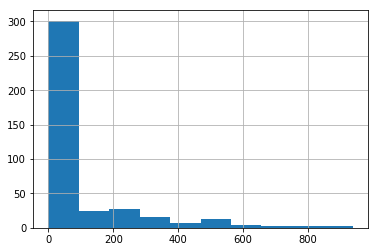

In [118]:
test_sample_df.arg_len.hist()
plt.show()

## Analyze automatic evaluation results:

In [11]:
eval_df = pd.read_pickle('../data/output/automatic_evaluation_results.pkl')

In [12]:
eval_df['arg_len'] = eval_df['argument'].apply(lambda x : len(x.split()))

In [13]:
eval_df = split_dataframe_per_conc_similarity(eval_df)

In [63]:
for clm_name, clm in pred_clms.items():
    eval_df['{}_opposing'.format(clm)] = eval_df.apply(lambda row: 1 if row['{}_stances'.format(clm)] * row['conclusion_stance'] < 0 else 0, axis=1)

<AxesSubplot:>

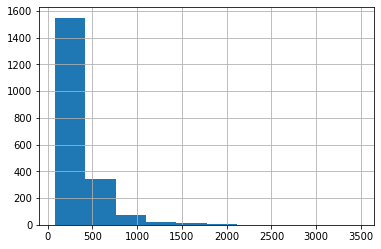

In [14]:
eval_df.arg_len.hist()

<AxesSubplot:>

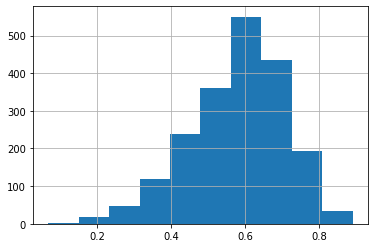

In [15]:
eval_df.max_sim_to_conclusion.hist()

In [67]:
pred_clms = {  
#     'BART Conclusion': 'bart_conc_attacks',
#     'Joint Prediction': 'joint_conc_baseline_attacks',
#     'Multi Conclusions (pipeline prediction)': 'multi_counter_pipeline',
     'Multi Conclusions (joint prediction)': 'multi_counter_joint',
#     'Stance Based CAG (w/o stance)': 'single_pred_counter_arguments_no_stance',
#     'Stance Based CAG (M- w/o stance)': 'pred_counter_arguments_no_stance',
#    'Known Conclusion': 'known_conc_attacks',
    'Masked Conclusion': 'masked_conc_attacks',
}

def analyze_effetiveness1(df, clm, measure, num_rows=10, num_clms=3):
    df  = df.sort_values('arg_len')
    chunk_size = int(len(df)/num_rows)
    score_dist = np.zeros((num_rows, num_clms))
    for i in range(0, num_rows) :
        df_row = df[i*chunk_size: (i+1) * chunk_size].copy()
        chunk_arg_len = round(df_row['arg_len'].mean(), 2)
        print('Number of samples is {} with average argument length = {}'.format(len(df_row), chunk_arg_len))
        #now split per similarity
        df_row = df_row.sort_values('max_sim_to_conclusion')
        chunk_size1 = int(len(df_row)/num_clms)
        for j in range(0, num_clms):
            df_chunk = df_row[j*chunk_size1: (j+1) * chunk_size1].copy()
            chunk_sim = round(df_chunk['max_sim_to_conclusion'].mean(), 2)
            print('Number of samples is {} with average similarity to conclusion = {}'.format(len(df_chunk), chunk_sim))
            score_dist[i,j] = round(df_chunk['{}_{}'.format(clm, measure)].mean(), 2)
    
    return score_dist

def analyze_effetiveness2(df, clm, measure, dimension='arg_len', num_buckets=5):
    df  = df.sort_values(dimension)
    chunk_size = int(len(df)/num_buckets)
    score_dist = []
    for i in range(0, num_buckets) :
        df_chunk = df[i*chunk_size: (i+1) * chunk_size].copy()
        chunk_dim = round(df_chunk[dimension].mean(), 2)
        print('Number of samples is {} with average dimension length = {}'.format(len(df_chunk), chunk_dim))
        value = round(df_chunk['{}_{}'.format(clm, measure)].mean(), 2)
        score_dist.append((chunk_dim, value))
    
    return score_dist

def analyze_effetiveness3(df, clm, measure, sim_thresholds=[0, 0.4, 0.7, 1.0], len_thresholds=[0, 300, 500, 1000]):
    score_dist = np.zeros((len(len_thresholds)-1, len(sim_thresholds)-1))
    for i in range(0, len(len_thresholds) - 1):
        df_row = df[(df.arg_len >= len_thresholds[i]) & (df.arg_len < len_thresholds[i+1])]
        chunk_arg_len = round(df_row['arg_len'].mean(), 2)
        print('Number of samples is {} with average argument length = {}'.format(len(df_row), chunk_arg_len))
        #now split per similarity
        for j in range(0, len(sim_thresholds) - 1):
            df_chunk = df_row[(df_row.max_sim_to_conclusion >= sim_thresholds[j]) & (df_row.max_sim_to_conclusion < sim_thresholds[j+1])]
            chunk_sim = round(df_chunk['max_sim_to_conclusion'].mean(), 2)
            print('Number of samples is {} with average similarity to conclusion = {}'.format(len(df_chunk), chunk_sim))
            score_dist[i,j] = round(df_chunk['{}_{}'.format(clm, measure)].mean(), 3)
    
    return score_dist

In [95]:
pred_clms = {  
#     'BART Conclusion': 'bart_conc_attacks',
#     'Joint Prediction': 'joint_conc_baseline_attacks',
#     'Multi Conclusions (pipeline prediction)': 'multi_counter_pipeline',
     'Multi Conclusions (joint prediction)': 'multi_counter_joint',
#     'Stance Based CAG (w/o stance)': 'single_pred_counter_arguments_no_stance',
    #'Stance Based CAG (M- w/o stance)': 'pred_counter_arguments_no_stance',
    'Known Conclusion': 'known_conc_attacks',
    'Masked Conclusion': 'masked_conc_attacks',
}

Number of samples is 500 with average dimension length = 0.41
Number of samples is 500 with average dimension length = 0.55
Number of samples is 500 with average dimension length = 0.63
Number of samples is 500 with average dimension length = 0.73
Number of samples is 500 with average dimension length = 0.41
Number of samples is 500 with average dimension length = 0.55
Number of samples is 500 with average dimension length = 0.63
Number of samples is 500 with average dimension length = 0.73
Number of samples is 500 with average dimension length = 0.41
Number of samples is 500 with average dimension length = 0.55
Number of samples is 500 with average dimension length = 0.63
Number of samples is 500 with average dimension length = 0.73


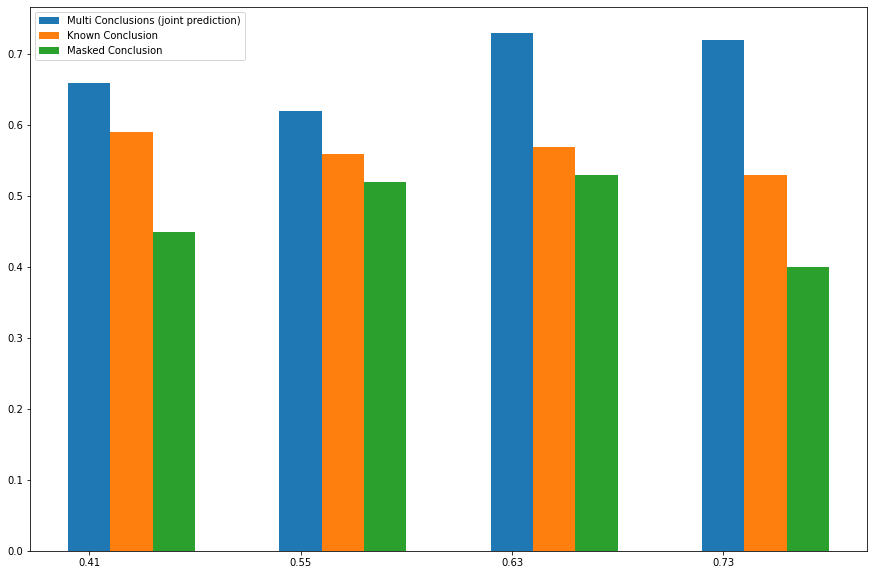

In [97]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'our_stance_score', 'max_sim_to_conclusion', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(x)), x)
plt.legend()
plt.savefig('./figures/conc_sim_to_stance_score_correlation.pdf')
plt.show()

Number of samples is 500 with average dimension length = 0.41
Number of samples is 500 with average dimension length = 0.55
Number of samples is 500 with average dimension length = 0.63
Number of samples is 500 with average dimension length = 0.73
Number of samples is 500 with average dimension length = 0.41
Number of samples is 500 with average dimension length = 0.55
Number of samples is 500 with average dimension length = 0.63
Number of samples is 500 with average dimension length = 0.73
Number of samples is 500 with average dimension length = 0.41
Number of samples is 500 with average dimension length = 0.55
Number of samples is 500 with average dimension length = 0.63
Number of samples is 500 with average dimension length = 0.73


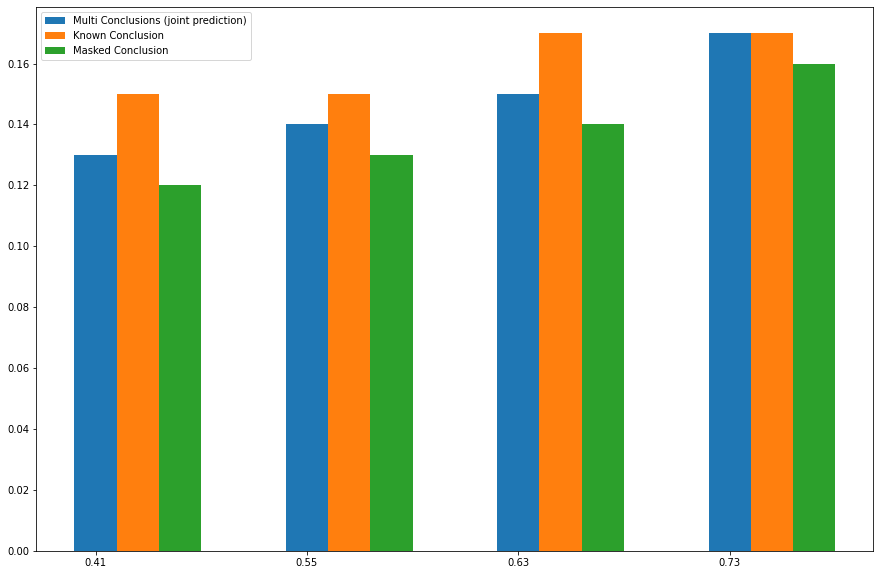

In [98]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'bert', 'max_sim_to_conclusion', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(x)), x)
plt.legend()
plt.savefig('./figures/conc_sim_to_bert_correlation.pdf')
plt.show()

Number of samples is 500 with average dimension length = 136.59
Number of samples is 500 with average dimension length = 211.43
Number of samples is 500 with average dimension length = 316.88
Number of samples is 500 with average dimension length = 653.48
Number of samples is 500 with average dimension length = 136.59
Number of samples is 500 with average dimension length = 211.43
Number of samples is 500 with average dimension length = 316.88
Number of samples is 500 with average dimension length = 653.48
Number of samples is 500 with average dimension length = 136.59
Number of samples is 500 with average dimension length = 211.43
Number of samples is 500 with average dimension length = 316.88
Number of samples is 500 with average dimension length = 653.48


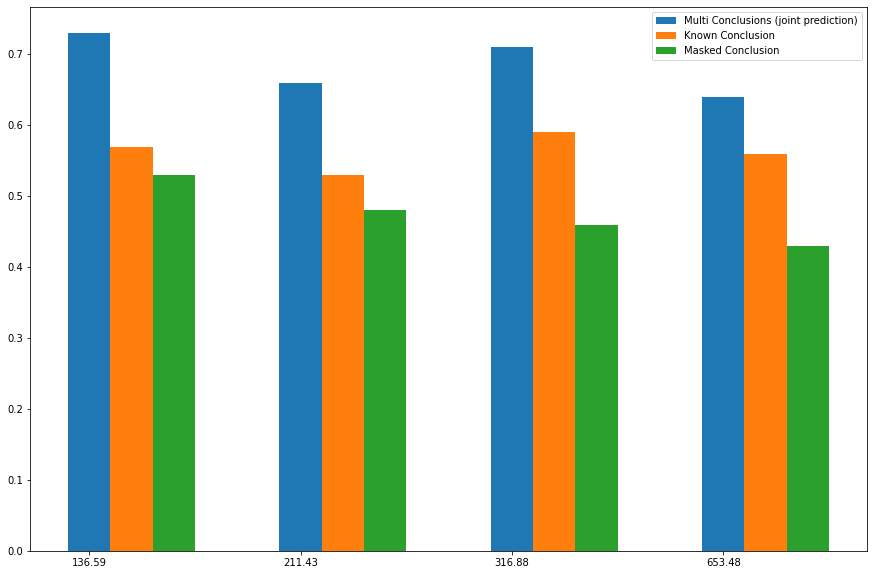

In [100]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'our_stance_score', 'arg_len', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/arg_len_to_stance_score_correlation.pdf')
plt.show()

Number of samples is 500 with average dimension length = 136.59
Number of samples is 500 with average dimension length = 211.43
Number of samples is 500 with average dimension length = 316.88
Number of samples is 500 with average dimension length = 653.48
Number of samples is 500 with average dimension length = 136.59
Number of samples is 500 with average dimension length = 211.43
Number of samples is 500 with average dimension length = 316.88
Number of samples is 500 with average dimension length = 653.48
Number of samples is 500 with average dimension length = 136.59
Number of samples is 500 with average dimension length = 211.43
Number of samples is 500 with average dimension length = 316.88
Number of samples is 500 with average dimension length = 653.48


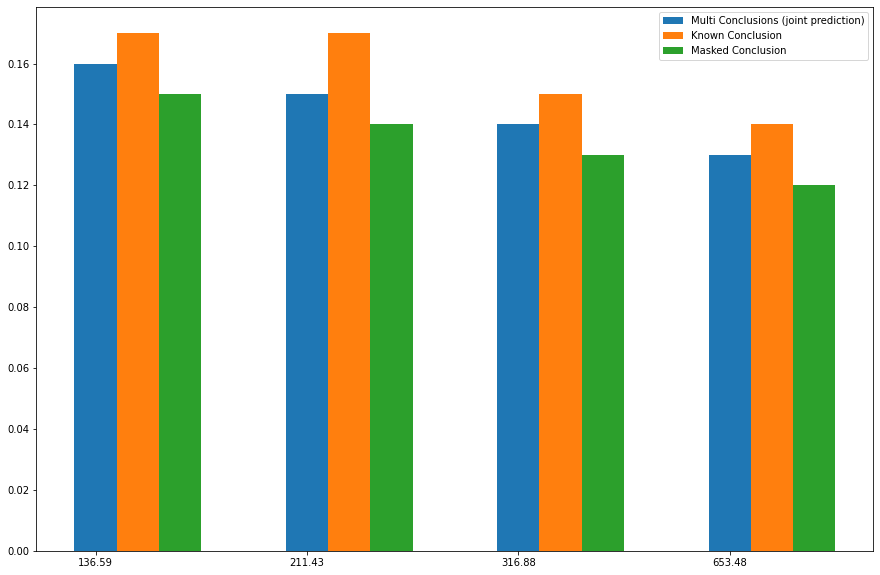

In [101]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'bert', 'arg_len', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/arg_len_to_bert_correlation.pdf')
plt.show()

In [179]:
#score_dist = analyze_effetiveness2(eval_df, 'masked_conc_attacks', 'bleu', len_thresholds=[0, 300, 600, 900, 1000], sim_thresholds=[0, 1.1])

---------

## Manual evaluation results:

In [73]:
mo_results_df = pd.read_excel('../data/manual_evaluation/results/counter_eval_mo.xlsx')
sr_results_df = pd.read_excel('../data/manual_evaluation/results/counter_eval_sr.xlsx')

eval_df = pd.read_pickle('../data/manual_evaluation/eval_sample_all.pkl')

all_ann_df = mo_results_df
all_ann_df['Rank2']    = sr_results_df['Rank'].tolist()
all_ann_df['Comment2'] = sr_results_df['Comment'].tolist()
all_ann_df['app_name'] = eval_df['Approach name'].tolist()
all_ann_df['avg_rank'] = all_ann_df.apply(lambda row: (row['Rank'] + row['Rank2'])/2, axis=1)

In [74]:
eval_df['num_sents'] = eval_df['Argument'].apply(lambda x: len(nltk.sent_tokenize(x)))
eval_df['num_count_sents'] = eval_df['Counter'].apply(lambda x: len(nltk.sent_tokenize(x)))

arg_len_dict = pd.Series(eval_df.num_sents.values, index=eval_df.ID).to_dict()

In [75]:
print('Avg argument num sents: ', eval_df.num_sents.mean())
print('Avg counter num sents: ', eval_df.num_count_sents.mean())

Avg argument num sents:  3.645
Avg counter num sents:  3.545


In [76]:
all_ann_df['argument_len'] = all_ann_df.ID.apply(lambda x: arg_len_dict[x] if x is not np.nan else 0)

In [77]:
all_ann_df.head()

,ID,Argument,Counter,Rank,Comment,Rank2,Comment2,app_name,avg_rank,argument_len
0,t3_bu5s4p,"abortion is murder and should be legal : to start, i m a catholic who would never get an abortion due to an accidental pregnancy. however, there are countless cases where abortion is necessary. if the mother s health is deteriorating due to the pregnancy, abortion is necessary to keep her alive. at that point, the baby can t live on its own, but the mother can, as long as she is no longer pregnant. further, if the child will die upon being born or is brain dead, then an abortion should be performed because pregnancy is dangerous and there s no point in carrying out something that could hurt the mother when there s literally no payoff for having the child because it could never live. if the pregnancy is caused by rape or incest, the emotional toll on the mother could be extremely substantial and no one has the right to declare that a woman be put through that constant pain. i would get an abortion for any of the above reasons. however, other people want to get abortions for accidental pregnancies. they want to get abortions because they can t afford the pregnancy, let alone raising the child. they want to get abortions so they can keep up in a competing field. they want to get abortions so they won t have disabled kids. they want to get abortions simply because they don t want kids. while i personally disagree with doing this, i do not know what their lives are like and cannot accurately judge them. neither can any politician. plenty of murders are legally justified in cases of self defense and i think abortion should be included, because it s practically the definition of self defense. someone is going to seriously harm, kill, or ruin your life, so you have the right to choose to kill them. i m not saying that i like the idea of killing a fetus, but it s justifiable, and laws are supposed to be just.","abortion is a medical procedure, not a medical necessity. if a woman is pregnant, she has a right to choose to abort. if she doesn't want to have the baby, she should be able to do so. abortion is not a choice, it is a necessity.",3,NaN,3,"Should the last sentence perhaps be switched? Abortion is a necessity, not a choice?\nThis would make more sense in the context of the argument, and would push the ranking of this argument to number 2.",pred_counter_arguments_no_stance,3.0,17
1,NaN,NaN,"i don't think it's fair to use self defense as a justification for abortion. self defense is the act of killing another human being. abortion is the action of killing a human being for no other reason than that it is in the best interest of the mother. you can argue about whether or not the mother's health is deteriorating due to the pregnancy, but that doesn't change the fact that the fetus is not in danger of dying.",1,I choose this as the most compatible counter argument because it directly attacks the main argument's attempt to use self defence as a justification for abortion.,1,"Directly challenges an argument posited in the original argument, and provides a good example to counter it.",multi_counter_joint,1.0,0
2,NaN,NaN,"the problem with this is that it violates the first amendment, which protects the right to life of the mother. the fetus is not a human being, and it does not have a right to exist outside of the womb. it is a part of the woman's body, and her body has no right to harm it.",4,"This is in no way against the main arguenment in fact, it offers a strong point that supports the argument.",2,NaN,multi_counter_pipeline,3.0,0
3,NaN,NaN,"i'm a catholic who would never get an abortion due to an accidental pregnancy. i believe that abortion should be legal in cases where the mother's health is deteriorating due to the pregnancy, or if the fetus is not viable and the mother is in danger of dying. i don't believe that the fetus should have the same rights as the mother, but i do think that it should be allowed to exist.",2,,4,This is essentia

In [78]:
all_ann_df[['app_name', 'Rank']].groupby('app_name').agg({'Rank': lambda x: np.mean(x)})

,Rank
app_name,
masked_conc_attacks,2.52
multi_counter_joint,2.43
multi_counter_pipeline,2.32
pred_counter_arguments_no_stance,2.71


In [79]:
all_ann_df[['app_name', 'Rank2']].groupby('app_name').agg({'Rank2': lambda x: np.mean(x)})

,Rank2
app_name,
masked_conc_attacks,2.71
multi_counter_joint,2.39
multi_counter_pipeline,2.35
pred_counter_arguments_no_stance,2.56


In [80]:
all_ann_df[['app_name', 'avg_rank']].groupby('app_name').agg({'avg_rank': lambda x: np.mean(x)})

,avg_rank
app_name,
masked_conc_attacks,2.615
multi_counter_joint,2.410
multi_counter_pipeline,2.335
pred_counter_arguments_no_stance,2.635


[(4.0, 12), (3.5, 22), (3.0, 13), (2.5, 19), (2.0, 12), (1.5, 8), (1.0, 14)]
[(4.0, 6), (3.5, 15), (3.0, 19), (2.5, 12), (2.0, 13), (1.5, 18), (1.0, 17)]
[(4.0, 13), (3.5, 12), (3.0, 16), (2.5, 12), (2.0, 15), (1.5, 14), (1.0, 18)]
[(4.0, 10), (3.5, 22), (3.0, 17), (2.5, 13), (2.0, 22), (1.5, 6), (1.0, 10)]


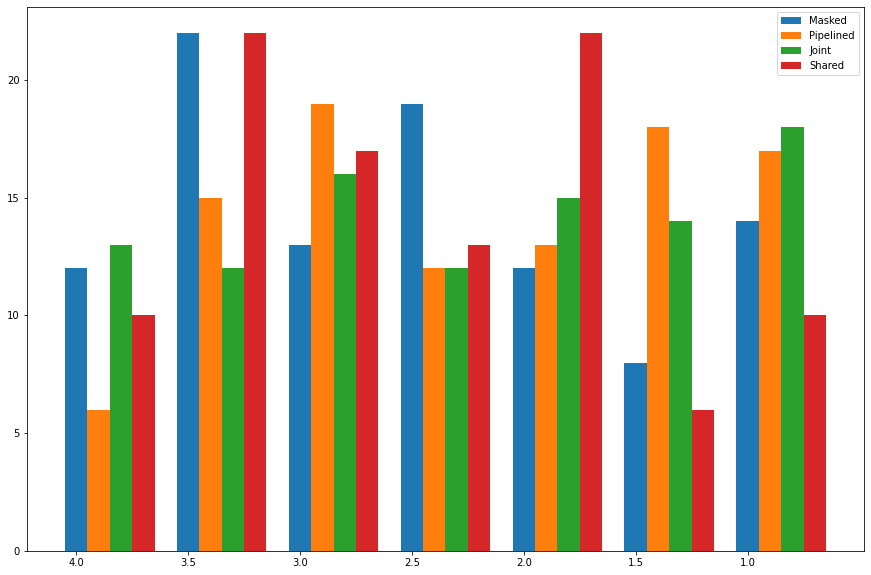

In [81]:
fig = plt.figure(figsize=(15,10))
width = 0.2
for i, item, in enumerate([('Masked', 'masked_conc_attacks'), ('Pipelined', 'multi_counter_pipeline'), ('Joint', 'multi_counter_joint'), ('Shared', 'pred_counter_arguments_no_stance')]):
    app = item[0]
    app_scores = sorted(all_ann_df[all_ann_df.app_name == item[1]]['avg_rank'].value_counts().to_dict().items(), key=lambda x: -x[0])
    print(app_scores)
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/manual_ranking_scores.pdf')
plt.show()

#### Conclusions quality:

In [69]:
fs_results_df = pd.read_excel('../data/manual_evaluation/results/conclusion_eval_fs.xlsx')
ji_results_df = pd.read_excel('../data/manual_evaluation/results/conclusion_eval_ji.xlsx')

conclusion_eval_df = pd.read_csv('../data/manual_evaluation/eval_conclusion_sample.csv')

all_ann_df = ji_results_df
all_ann_df['Valid2']    = fs_results_df['Valid'].tolist()
all_ann_df['app_name'] = conclusion_eval_df['Approach name'].tolist()
all_ann_df['avg_score'] = all_ann_df.apply(lambda row: (row['Valid'] + row['Valid2'])/2, axis=1)

In [70]:
all_ann_df.head()

,Unnamed: 0,ID,Argument,Conclusion,Valid,Valid2,app_name,avg_score
0,0,t3_aiwppt,"models of climate change predict, in the very near future, existential threats to humanity. in particular are weather effects that will drastically reduce food supplies and access to potable water. in the western hemisphere, it is obvious that this will be far more disastrous to those south of the us border where, even right now, access to food and water is a real issue for millions of people. while the proposed border wall may not be entirely justifiable in its ability to stop current illegal immigration and illicit transport of contraband, in the event of a massive migration, greater in scale by magnitudes than that seen in europe, a border wall will be absolutely necessary to stop the influx. now, one might argue that it is morally unjustifiable to turn away the starving masses, which is a nice sentiment. however, this sentiment fails at practicality: this country s own food supply will also be taxed and to let in millions will only ensure that even more people will starve together as opposed to some living and some dying. if one were to argue that we caused more pollution than they did, and so should not live whilst they die, then the rational answer is to go ahead and commit suicide now so that you will not contribute more pollution or reduce any more resources that you feel others have more right to possess. doing otherwise is only to make the moral judgement for others by removing their agency. would a person who claims that we don t deserve to live instead of these potential refugees feel justified to murder infants now? if not, then how could they argue that an arbitrary amount of time will serve to justify that same death for wrongs committed at the same time that the same person was an infant? or before they were even born since the worst of the pollution caused by the us was done between 40 to 70 years ago ? it is not justifiable because neither the infant nor the potential refugee had a part in the damage done. so, what is left to argue? in the event of a refugee crisis, will a wall stop more refugees than no wall? obviously it will. is the cost of constructing one now less than it will be in the future? yes, it is, and it would have been cheaper still had it been built 5, 10, or 20 years ago. the worst case scenario of building the wall now is that it would be totally ineffective at the stated purpose and it would cost the government money that would otherwise be earmarked off to some other pork barrel project. that is very little risk when considered against the future benefit that can be provided.",Pollution is not morally justified and building a border wall is the best way to stop the immigration crisis.,3,2,joint-learning,2.5
1,1,NaN,NaN,To believe Climate Change models are correct but to oppose a border wall is an irrational position regardless of politics.,3,3,ground-truth,3.0
2,2,NaN,NaN,Drinking water and committing suicide at an infant's birth is morally unjustifiable.,1,1,pipeline-learning,1.0
3,3,NaN,NaN,"Climate change is a real issue, and building a border wall is necessary to stop the influx of refugees.",3,3,joint-learning,3.0
4,4,NaN,NaN,"Climate change is far more of an issue than the proposed border wall, it has a much greater risk of increasing the risk of global extinction than a wall.",1,1,pipeline-learning,1.0


In [71]:
all_ann_df[['app_name', 'avg_score']].groupby('app_name').agg({'avg_score': lambda x: np.mean(x)})

,avg_score
app_name,
ground-truth,2.390
joint-learning,1.905
joint-learning-two-decoders,2.025
pipeline-learning,1.420
